In [1]:
import pandas as pd
from example.nuscenes.av_discretizer  import AVDiscretizer
from example.nuscenes.transition import TransitionRecorded
from nuscenes import NuScenes
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
from example.nuscenes.environment import SelfDrivingEnvironment


In [2]:
# This is the path where you stored your copy of the nuScenes dataset.

#MINI
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)


#FULL
#DATAROOT = Path('/media/saramontese/Riccardo 500GB/NuScenesDataset/data/sets/nuscenes')
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.451 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# Data Analysis


The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

# Load the CSV data into a DataFrame


In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}
df = pd.read_csv(DATAROOT / 'dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])

#df = pd.read_csv('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes/dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])




df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
0,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000
1,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592
2,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.200261,"[-0.16222999791894513, 0.010261981974878865, -...",325.362312,661.686833,0.0,2.815673,4.972301,-0.331650,-0.005091,0.031316,1.984681
3,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.040541,2.124192
4,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681


In [4]:
df.shape

(384, 13)

### Compute deltas for relevant columns

In [5]:
# Assuming 'df' is your DataFrame and it has 'x', 'y', 'z' columns for position
delta_df = pd.DataFrame()
delta_df['x_diff'] = df.groupby('scene_token')['x'].diff()
delta_df['y_diff'] = df.groupby('scene_token')['y'].diff()
delta_df['z_diff'] = df.groupby('scene_token')['z'].diff()
delta_df['velocity_diff'] = df.groupby('scene_token')['velocity'].diff()
delta_df['acceleration_diff'] = df.groupby('scene_token')['acceleration'].diff()
delta_df['yaw_diff'] = df.groupby('scene_token')['yaw'].diff()
delta_df['heading_change_rate_diff'] = df.groupby('scene_token')['heading_change_rate'].diff()


In [6]:
# Assuming 'df' is your DataFrame and it has 'x', 'y', 'z' columns for position
abs_df = pd.DataFrame()
abs_df['abs_x_diff'] = df.groupby('scene_token')['x'].diff().abs()
abs_df['abs_y_diff'] = df.groupby('scene_token')['y'].diff().abs()
abs_df['abs_z_diff'] = df.groupby('scene_token')['z'].diff().abs()
abs_df['abs_velocity_diff'] = df.groupby('scene_token')['velocity'].diff().abs()
abs_df['abs_acceleration_diff'] = df.groupby('scene_token')['acceleration'].diff().abs()
abs_df['abs_yaw_diff'] = df.groupby('scene_token')['yaw'].diff().abs()
abs_df['abs_heading_change_rate_diff'] = df.groupby('scene_token')['heading_change_rate'].diff().abs()


### Compute statistics to understand their distribution

Original Dataset

In [7]:
stats = df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']].describe()
stats.loc[['mean', 'std', 'min', 'max']]

,velocity,acceleration,yaw,heading_change_rate
mean,5.648337e+00,0.044867,0.199002,-0.023742
std,4.702125e+00,0.592547,1.985583,1.079821
min,1.307423e-07,-3.251616,-3.045028,-12.232000
max,1.516489e+01,1.661893,3.120576,12.088103


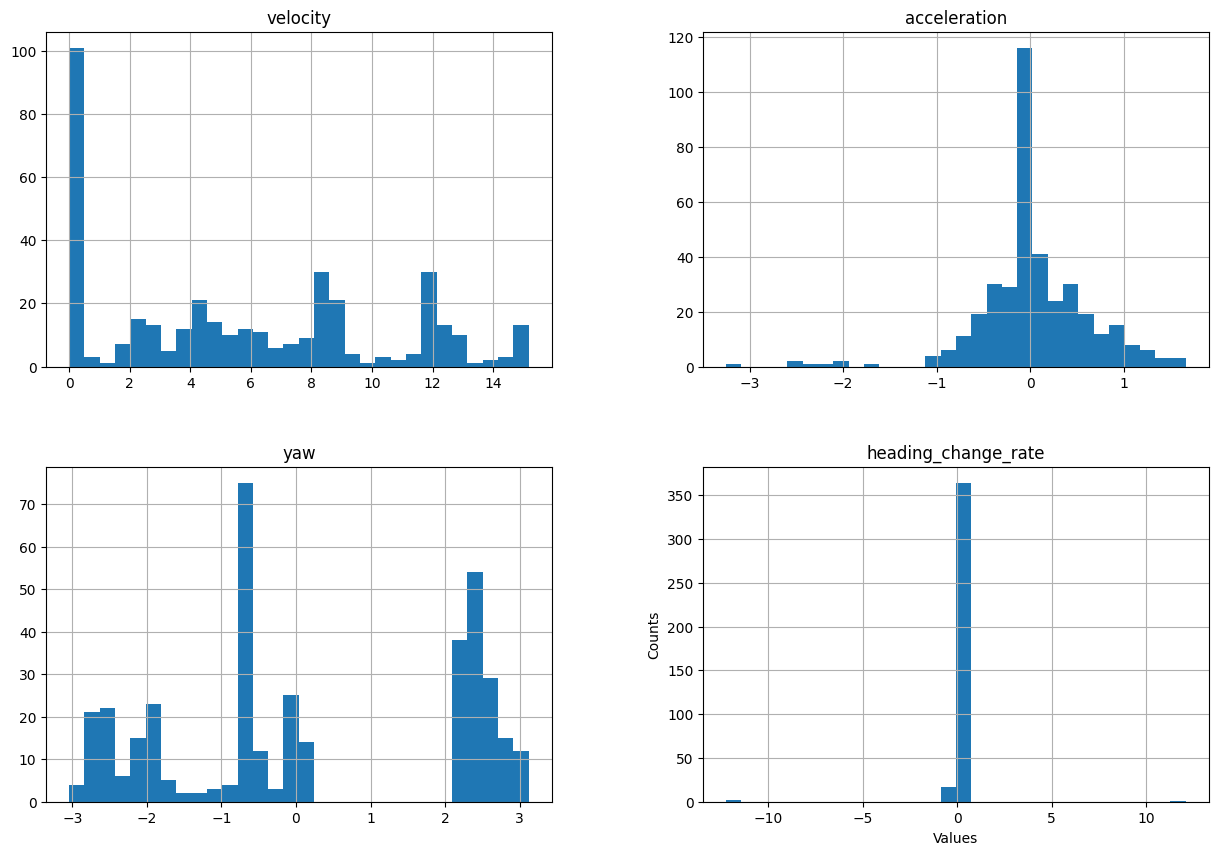

In [8]:
df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Correlation matrix

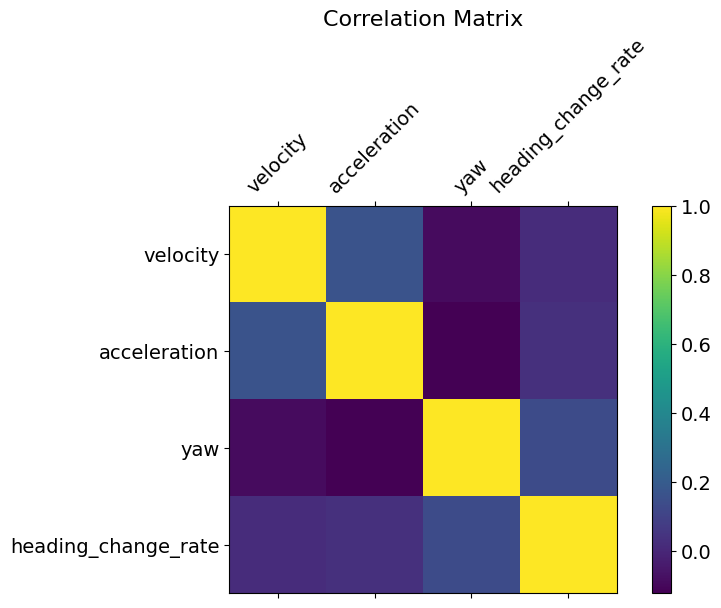

In [9]:
f = plt.figure(figsize=(9, 5))
numeric_df = df[['velocity', 'acceleration', 'yaw', 'heading_change_rate']]
plt.matshow(numeric_df.corr(), fignum=f.number)
plt.xticks(range(numeric_df.select_dtypes(['number']).shape[1]), numeric_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_df.select_dtypes(['number']).shape[1]), numeric_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Variation  Dataset

In [10]:
stats = delta_df[['x_diff', 'y_diff', 'z_diff', 'velocity_diff', 'acceleration_diff', 'yaw_diff', 'heading_change_rate_diff']].describe()
stats.loc[['mean', 'std', 'min', 'max']]


,x_diff,y_diff,z_diff,velocity_diff,acceleration_diff,yaw_diff,heading_change_rate_diff
mean,0.377432,-0.550399,0.0,0.021818,-0.006074,-0.012051,0.001365
std,2.631656,2.476047,0.0,0.293477,0.370391,0.547138,1.591383
min,-4.172880,-5.705460,0.0,-1.298237,-1.662225,-6.121174,-12.602398
max,6.338054,4.971892,0.0,0.828863,1.588390,6.042274,12.640437


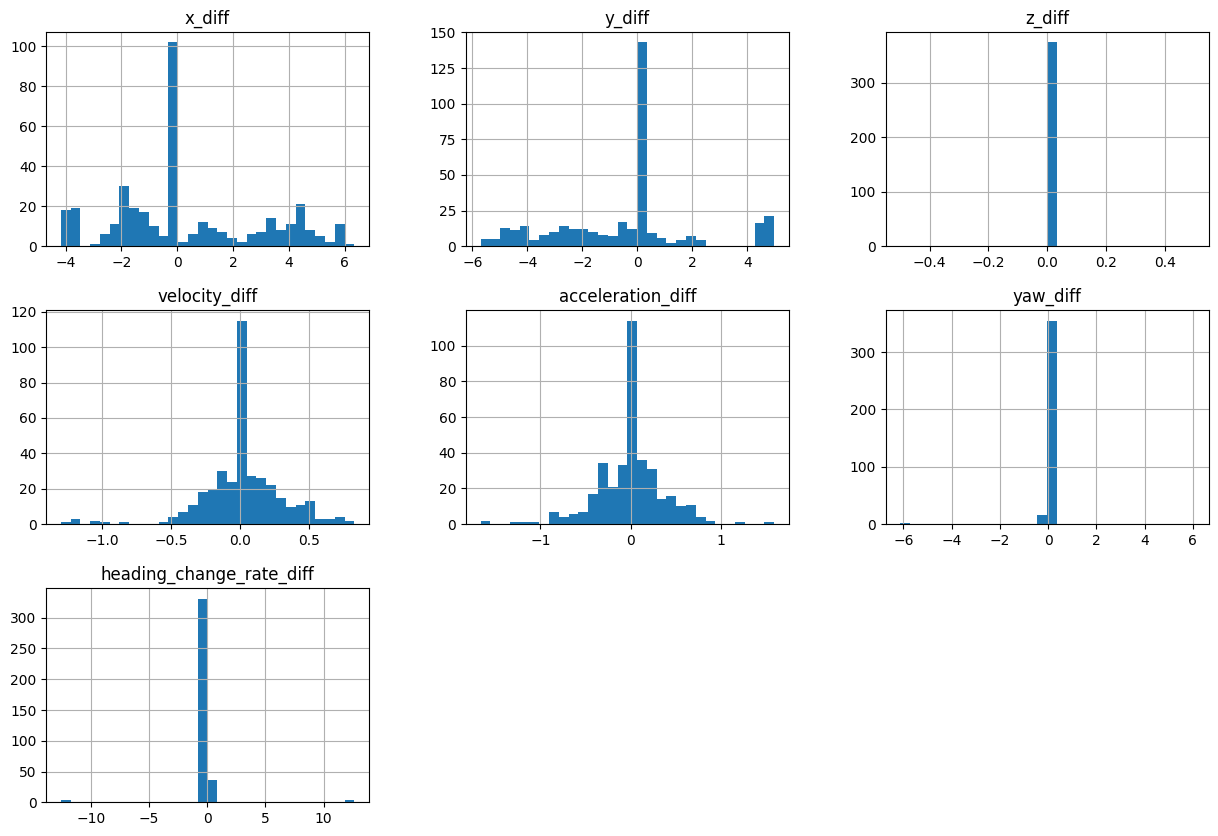

In [11]:
delta_df[['x_diff', 'y_diff', 'z_diff', 'velocity_diff', 'acceleration_diff', 'yaw_diff', 'heading_change_rate_diff']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Correlation Matrix


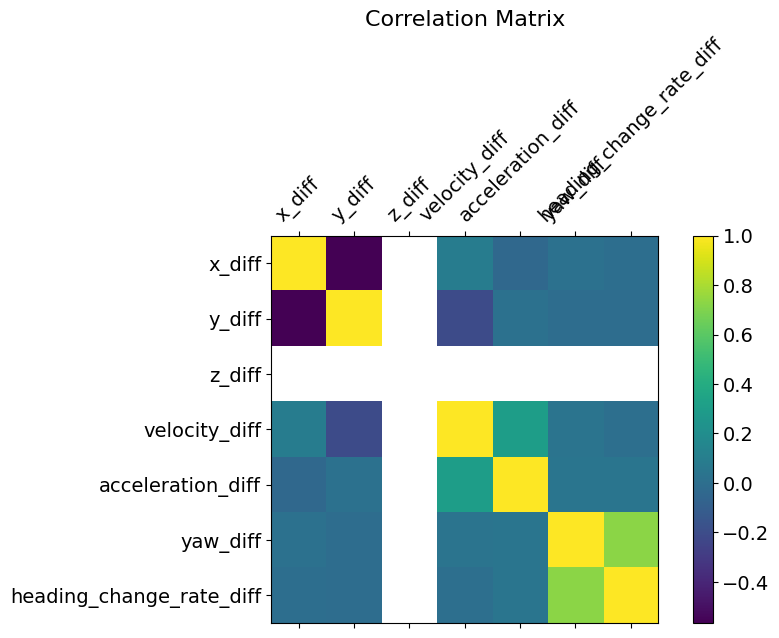

In [12]:
f = plt.figure(figsize=(9, 5))
plt.matshow(delta_df.corr(), fignum=f.number)
plt.xticks(range(delta_df.select_dtypes(['number']).shape[1]), delta_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(delta_df.select_dtypes(['number']).shape[1]), delta_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Absolute Variation Dataset

In [13]:
abs_stats = abs_df[['abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'abs_velocity_diff', 'abs_acceleration_diff', 'abs_yaw_diff', 'abs_heading_change_rate_diff']].describe()
abs_stats.loc[['mean', 'std', 'min', 'max']]


,abs_x_diff,abs_y_diff,abs_z_diff,abs_velocity_diff,abs_acceleration_diff,abs_yaw_diff,abs_heading_change_rate_diff
mean,2.004027e+00,1.724144e+00,0.0,0.191920,2.483478e-01,6.820299e-02,0.214334
std,1.744007e+00,1.858472e+00,0.0,0.222876,2.745617e-01,5.429931e-01,1.576844
min,3.825562e-09,6.531832e-08,0.0,0.000001,8.449540e-07,2.501108e-07,0.000006
max,6.338054e+00,5.705460e+00,0.0,1.298237,1.662225e+00,6.121174e+00,12.640437


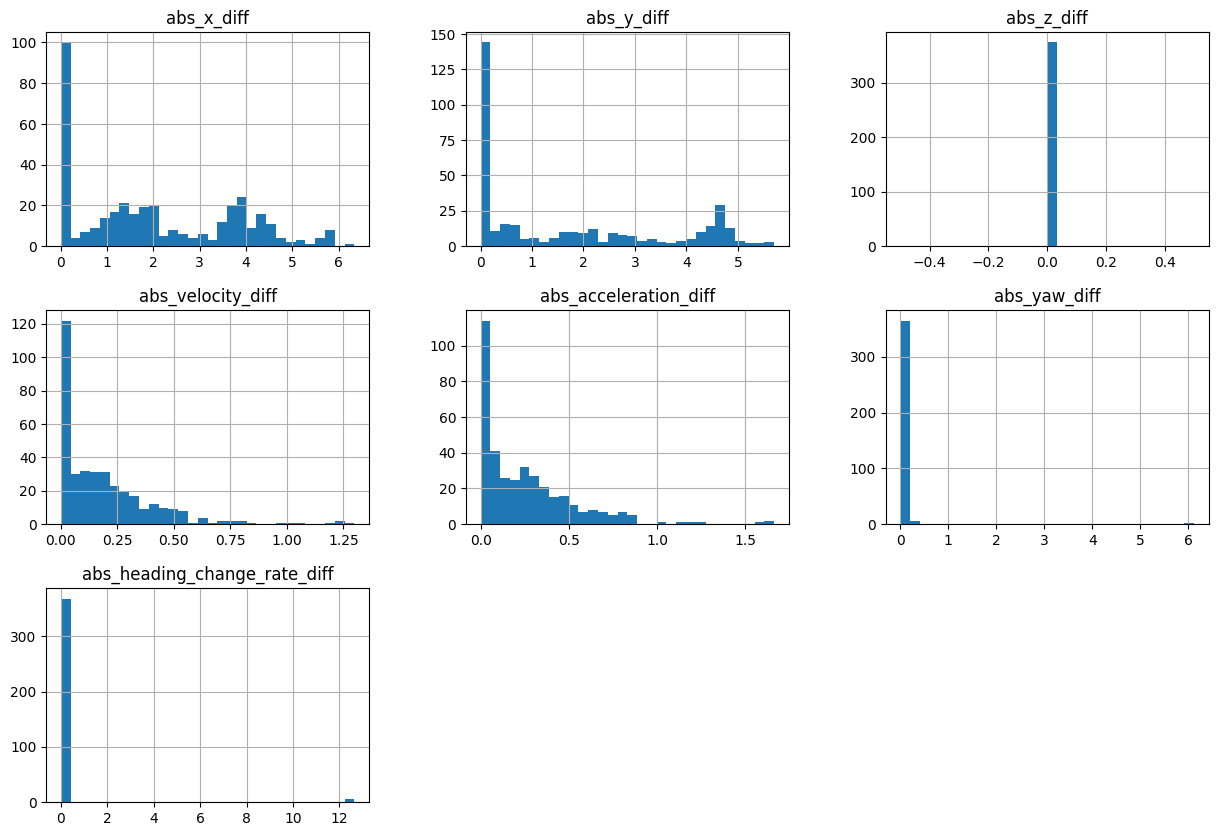

In [14]:
abs_df[['abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'abs_velocity_diff', 'abs_acceleration_diff', 'abs_yaw_diff', 'abs_heading_change_rate_diff']].hist(bins=30, figsize=(15, 10))

plt.xlabel("Values")
plt.ylabel("Counts")
plt.show()

Interpretation:
- x_diff:
- y_diff:
Since these have broader distributions, setting a threshold might require considering the context of the movement. If you're looking to detect significant lateral movements (e.g., lane changes), you might set a threshold around the higher frequency lower-end values.

- z_diff: The z differences are concentrated near zero with a very sharp peak, indicating that there is very little change in the vertical position, which is expected for a vehicle traveling on relatively flat surfaces. (0.05-0.1)


- velocity_diff: high concentration at the lower end, suggesting that velocity changes between consecutive measurements are generally small, with occasional larger changes.
    Plausible threshold to detect meaningful acceleration or deceleration might be set just above the most frequent low-end changes, possibly in the range where the histogram bars start to significantly lower. (0.1-0.2 m/s)


- acceleration_diff: most acceleration changes are close to zero, with a few instances of larger differences. This pattern is typical for driving in urban environments, where acceleration and deceleration are frequent but not extreme. Threshold might be set at a value that excludes the majority of these minor changes but captures the less frequent larger changes. (5-10)


- yaw_diff: histogram is highly skewed towards smaller values, indicating that most of the time, there are only slight changes in orientation, which corresponds to driving mostly straight with occasional turns. (0.1-0.2)


- heading_change_rate_diff:Similar to yaw_diff, the histogram for heading change rate differences is skewed towards smaller values. The vehicle mostly maintains its heading with only slight variations within the sampled timeframe. (0.01-0.02)



# Determine Trajectory in Scene's Instances

In [15]:
# Initialize your AVDiscretizer
av_discretizer = AVDiscretizer()


### Let's do an example of computing trajectory of an instance of a scene. We then check if the images of the instace match the actions in the trajectory.

In [16]:
df['scene_token'].unique()

array(['2fc3753772e241f2ab2cd16a784cc680',
       '325cef682f064c55a255f2625c533b75',
       '6f83169d067343658251f72e1dd17dbc',
       'bebf5f5b2a674631ab5c88fd1aa9e87a',
       'c5224b9b454b4ded9b5d2d2634bbda8a',
       'cc8c0bf57f984915a77078b10eb33198',
       'd25718445d89453381c659b9c8734939',
       'de7d80a1f5fb4c3e82ce8a4f213b450a',
       'e233467e827140efa4b42d2b4c435855',
       'fcbccedd61424f1b85dcbf8f897f9754'], dtype=object)

Select a scene and test the  algorithm


In [17]:
scene_test = 'bebf5f5b2a674631ab5c88fd1aa9e87a'
instance1_example_df = df[df['scene_token']==scene_test]
instance1_example_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
117,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:33.200183,"[0.9997929727538482, -0.016152305750894613, -0...",1780.747230,866.457240,0.0,0.024381,8.185916,0.986673,0.000055,0.000000,0.000000
118,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:33.650312,"[0.9998022092861187, -0.015130044333050515, -0...",1784.563552,866.529807,0.0,0.025816,8.479817,0.652925,0.003189,0.020490,3.816957
119,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:34.150195,"[-0.9997849035463522, 0.015034734236142825, -0...",1788.868911,866.606685,0.0,0.028432,8.614106,0.268641,0.005232,0.034284,4.305909
120,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:34.550004,"[-0.9997533463143026, 0.015583503535431465, -0...",1792.295493,866.679112,0.0,0.031605,8.572463,-0.104158,0.007936,0.025012,3.427256
121,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:34.949783,"[-0.999757477107573, 0.014142393272879727, 0.0...",1795.704829,866.764818,0.0,0.033744,8.530746,-0.104349,0.005351,0.022069,3.410342
122,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:35.449675,"[-0.9997730328168501, 0.010707596019344248, 0....",1800.040729,866.864654,0.0,0.036661,8.675973,0.290517,0.005835,0.046502,4.336800
123,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:35.949554,"[-0.9997284293038398, 0.0113370846014813, 0.00...",1804.249912,866.978742,0.0,0.040696,8.423495,-0.505080,0.008074,0.040266,4.210536
124,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:36.399680,"[-0.9997073223214882, 0.011178170352553354, 0....",1807.990843,867.097895,0.0,0.042913,8.315070,-0.240877,0.004924,0.033146,3.742682
125,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:36.900138,"[-0.9996069825359233, 0.01475966089454273, 0.0...",1812.242381,867.254283,0.0,0.047669,8.501038,0.371596,0.009504,0.026145,4.254332
126,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:37.400558,"[-0.9995864948616396, 0.014064254863061424, -0...",1816.572582,867.442139,0.0,0.049560,8.661273,0.320202,0.003779,0.018696,4.334234


I compute the trajectoy of the scene. Theb, for each sample in the scene, I retrive the images :

In [18]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(instance1_example_df)
# After processing all trajectories:
recorder.process_and_save_transitions(trajectory, av_discretizer.unique_states)

State 0: [0.0, 0.0, 8.185916400546434, 0.0243809127521553, 5.5280221261210464e-05, 0.9866729026571752, Timestamp('2018-08-27 15:51:33.200183')]
Discretized state: 0 [(445, 216)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>, <Action.GAS: 4>}

State 1: [0.0204902001644104, 3.816956541049537, 8.479816982325772, 0.0258161513712863, 0.0031885051154913, 0.6529252320542296, Timestamp('2018-08-27 15:51:33.650312')]
Discretized state: 1 [(446, 216)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 2: [0.03428355445337, 4.305908571346248, 8.614105804071992, 0.0284317504580207, 0.0052324225603477, 0.2686405053706952, Timestamp('2018-08-27 15:51:34.150195')]
Discretized state: 2 [(447, 216)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 3: [0.0250124999878748, 3.4272564124163893, 8.572462558896854, 0.0316045914072956, 0.0079358917615035, -0.1041578483104122, Timestamp('2018-08-27 15:51:34.

Plot trend of state in time for each instance of a scene.

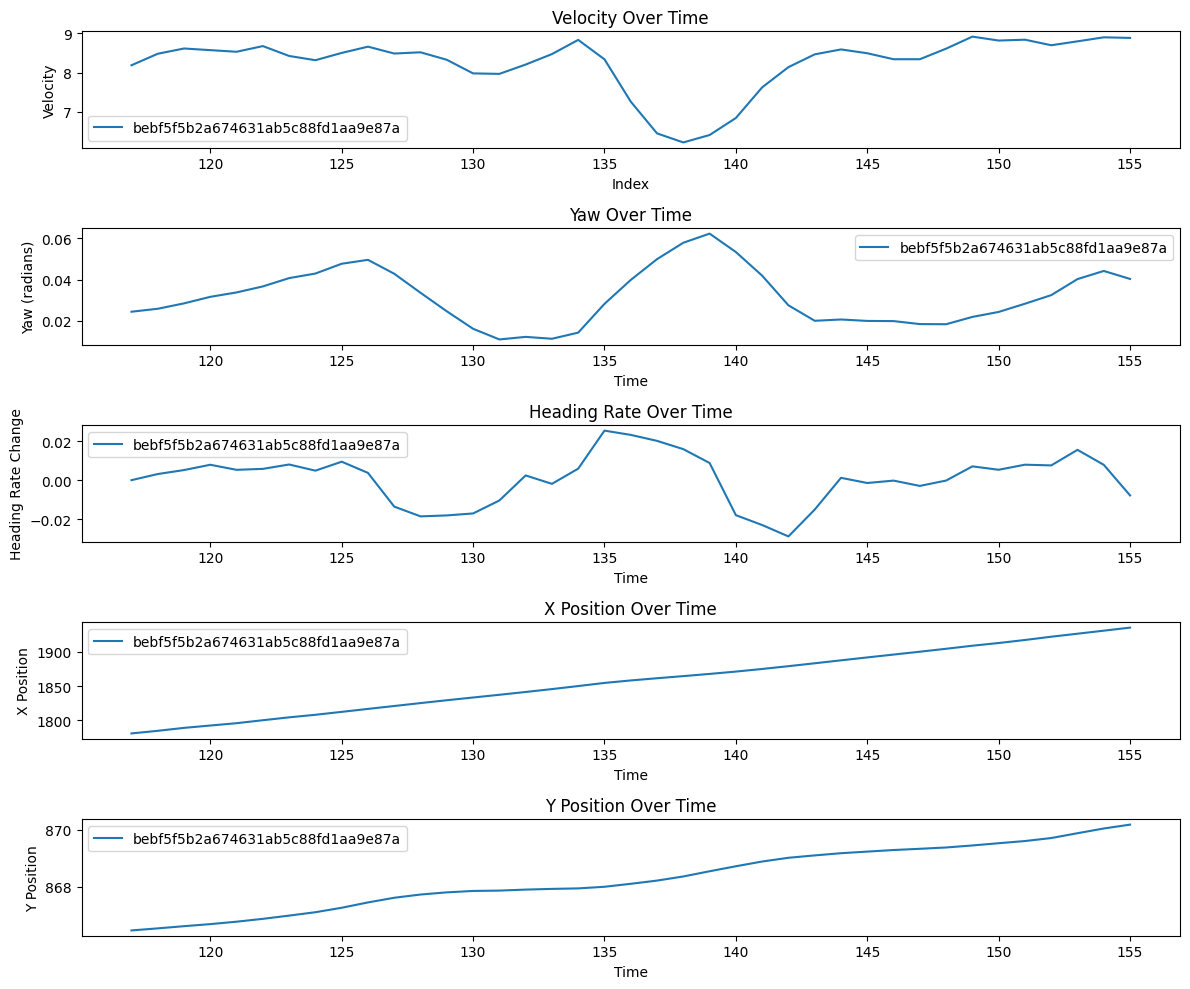

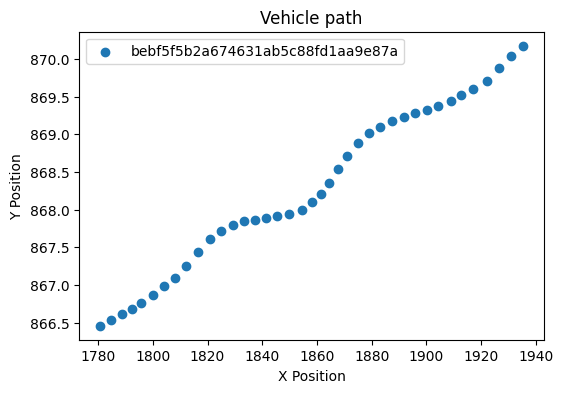

In [19]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=instance_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=instance_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=instance_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=instance_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=instance_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for instance_token, group in instance1_example_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=instance_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [20]:
#nuscenes.render_scene(scene_test)



## All scenes trajectory information


Now, apply the above to all scenes in mini dataset.

In [21]:
av_discretizer = AVDiscretizer()
trajectory = av_discretizer.compute_trajectory(df)

State 0: [0.0, 0.0, 5.108549775006556, 2.8287073423413176, -0.0453298240761698, -0.0348037318593867, Timestamp('2018-08-30 19:25:09.301132')]
Discretized state: 0 [(82, 165)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.STRAIGHT: 11>}

State 1: [0.0456478454936385, 2.5515920468546924, 5.10469490440442, 2.817705897134056, -0.0220058832146411, -0.007710789871694, Timestamp('2018-08-30 19:25:09.801064')]
Discretized state: 1 [(81, 165)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.STRAIGHT: 11>}

State 2: [0.0313156638906143, 1.9846806565211763, 4.972301147669266, 2.815673479305952, -0.0050912652853189, -0.3316501795733787, Timestamp('2018-08-30 19:25:10.200261')]
Discretized state: 2 [(81, 165)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.STRAIGHT: 11>, <Action.BRAKE: 5>}

State 3: [0.0405408994690575, 2.1241916563087795, 4.709219465049271, 2.807967705113446, -0.0170801794347065, -0.5831318479983395, Timestamp('2018-08-30 19:25:10.651414')]
Disc

In [22]:

transition = TransitionRecorded()
transition.process_and_save_transitions(trajectory, av_discretizer.unique_states, path='/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes/')

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526

# Policy Graph Generation

In [23]:
path_pg_data = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
env = SelfDrivingEnvironment(0,0,0,0)


/home/saramontese/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [24]:
av_discretizer = AVDiscretizer()

pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

In [25]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 235
Number of edges: 284


In [26]:
arbitrary_state = list(pg.nodes)[0]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

((82, 165), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
  Times visited: 1
  p(s):          0.003


In [27]:
arbitrary_edge = list(pg.edges)[0]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    ((82, 165), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
Action:  5
To:      ((81, 165), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
  Times visited:      1
  p(s_to,a | s_from): 1.000


In [28]:
len(pg._trajectories_of_last_fit)


0